In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import tqdm
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import wandb

from utils import *
from train import *

# for tensorboard
from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter()

# Using embedding
In this experiment, we sample data not only from uniform distribution but from variety of distributions. We then use this data for encoder and feed its output throught cross-attention mechanism to the decoder. The decoder takes the sequence with missing tokens and tries to fill in the gaps.

### Architecture
- We use multihead attention for the encoder and vanilla attention for the decoder.
- In the encoder, before splitting heads I "merge" the 5 sequences through linear layer.

In [2]:
import os
print(os.getcwd())

/Users/mariayuffa/semester-project-1


In [3]:
# Sequences for decoder
final_chains_train = np.load('data/final_chains_T=1_num_iters=20_J_experiment_train.npy')
chains_train = final_chains_train.copy()
chains_train[final_chains_train==-1] = 0
chains_train[final_chains_train==1] = 1
#dec_samples_train = torch.tensor(chains_train, dtype=torch.long)
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", final_chains_train.shape)

final_chains_test = np.load('data/final_chains_T=1_num_iters=20_J_experiment_test.npy')
chains_test = final_chains_test.copy()
chains_test[final_chains_test==-1] = 0
chains_test[final_chains_test==1] = 1
#dec_samples_test = torch.tensor(chains_test, dtype=torch.long)
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", final_chains_test.shape)


# Sequences for encoder
final_chains_encoder_train = np.zeros((1000,5,200))
final_chains_encoder_test = np.zeros((1000,5,200))
for i in range(1,6):
    final_chains_encoder_train[:,i-1,:] = np.load(f'data/2_spin/cluster_ising/final_chains_T=1_num_iters=5_J_experiment_train_{i}.npy')
    final_chains_encoder_test[:,i-1,:] = np.load(f'data/2_spin/cluster_ising/final_chains_T=1_num_iters=5_J_experiment_test_{i}.npy') 

print("Loaded train sequences of proteins for encoder distribution:", final_chains_encoder_train.shape)
print("Loaded test sequences of proteins for encoder distribution:", final_chains_encoder_test.shape)

samples_train = final_chains_encoder_train.copy() 
samples_train[final_chains_encoder_train==-1] = 0
samples_train[final_chains_encoder_train==1] = 1
samples_train = samples_train.reshape((5000,200))
#enc_samples_train = torch.tensor(samples_train, dtype=torch.long)

samples_test = final_chains_encoder_test.copy()
samples_test[final_chains_encoder_test==-1] = 0
samples_test[final_chains_encoder_test==1] = 1
samples_test = samples_test.reshape((5000,200))
#print(samples_test.shape)
#enc_samples_test = torch.tensor(samples_test, dtype=torch.long)


Loaded train sequences of proteins sampled from Boltzmann distribution: (1000, 200)
Loaded test sequences of proteins sampled from Boltzmann distribution: (1000, 200)
Loaded train sequences of proteins for encoder distribution: (1000, 5, 200)
Loaded test sequences of proteins for encoder distribution: (1000, 5, 200)


In [4]:
batch_size = 32
enc_train_loader, enc_test_loader = create_dataloaders(samples_train, samples_test, batch_size, flag_float=False)
dec_train_loader, dec_test_loader = create_dataloaders(chains_train, chains_test, batch_size, flag_float=False)

In [5]:
'''
# Sequences for decoder
final_chains_train = np.load('data/final_chains_T=1_num_iters=20_J_experiment_train.npy')
chains_train = final_chains_train.copy()
chains_train[final_chains_train==-1] = 1
chains_train[final_chains_train==1] = 3
tensor_chains_train = torch.tensor(chains_train, dtype=torch.long)
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", final_chains_train.shape)

final_chains_test = np.load('data/final_chains_T=1_num_iters=20_J_experiment_test.npy')
chains_test = final_chains_test.copy()
chains_test[final_chains_test==-1] = 1 
chains_test[final_chains_test==1] = 3 
tensor_chains_test = torch.tensor(chains_test, dtype=torch.long)
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", final_chains_test.shape)


# Sequences for encoder
k = 0
final_chains_encoder_train = np.zeros((1000,5,200))
final_chains_encoder_train[:,0,:] = np.load('data/2_spin/final_chains_T=1_num_iters=400_J=10_test.npy') 
final_chains_encoder_test = np.zeros((1000,5,200))
final_chains_encoder_test[:,0,:] = np.load('data/2_spin/final_chains_T=1_num_iters=400_J=10_test.npy') 
for i in range(20,100,20):
    k+=1
    final_chains_encoder_train[:,k,:] = np.load('data/2_spin/final_chains_T=1_num_iters=400_J='+str(i)+'_train.npy')
    final_chains_encoder_test[:,k,:] = np.load('data/2_spin/final_chains_T=1_num_iters=400_J='+str(i)+'_test.npy') 

print("Loaded train sequences of proteins for encoder distribution:", final_chains_encoder_train.shape)
print("Loaded test sequences of proteins for encoder distribution:", final_chains_encoder_test.shape)

samples_train = final_chains_encoder_train.copy() 
samples_train[final_chains_encoder_train==-1] = 1
samples_train[final_chains_encoder_train==1] = 3
tensor_samples_train = torch.tensor(samples_train, dtype=torch.long)

samples_test = final_chains_encoder_test.copy()
samples_test[final_chains_encoder_test==-1] = 1
samples_test[final_chains_encoder_test==1] = 3
tensor_samples_test = torch.tensor(samples_test, dtype=torch.long)
'''

'\n# Sequences for decoder\nfinal_chains_train = np.load(\'data/final_chains_T=1_num_iters=20_J_experiment_train.npy\')\nchains_train = final_chains_train.copy()\nchains_train[final_chains_train==-1] = 1\nchains_train[final_chains_train==1] = 3\ntensor_chains_train = torch.tensor(chains_train, dtype=torch.long)\nprint("Loaded train sequences of proteins sampled from Boltzmann distribution:", final_chains_train.shape)\n\nfinal_chains_test = np.load(\'data/final_chains_T=1_num_iters=20_J_experiment_test.npy\')\nchains_test = final_chains_test.copy()\nchains_test[final_chains_test==-1] = 1 \nchains_test[final_chains_test==1] = 3 \ntensor_chains_test = torch.tensor(chains_test, dtype=torch.long)\nprint("Loaded test sequences of proteins sampled from Boltzmann distribution:", final_chains_test.shape)\n\n\n# Sequences for encoder\nk = 0\nfinal_chains_encoder_train = np.zeros((1000,5,200))\nfinal_chains_encoder_train[:,0,:] = np.load(\'data/2_spin/final_chains_T=1_num_iters=400_J=10_test.npy\

In [9]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout, num_distr=5):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(num_spins, embed_dim)
        self.decoder_embedding = nn.Embedding(num_spins, embed_dim)

        #self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        #self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)
        self.encoder_layer = EncoderLayer(embed_dim, proj_layer_dim, dropout, num_distr)
        self.decoder_layer = DecoderLayer(embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout)
        self.fc = nn.Linear(embed_dim, num_spins)

    def forward(self, src, tgt):
        #src_mask, tgt_mask = self.generate_mask(src, tgt)
        #src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        #tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        src_embedded = self.positional_encoding(self.encoder_embedding(src))
        tgt_embedded = self.positional_encoding(self.decoder_embedding(tgt))

        enc_output = self.encoder_layer(src_embedded)
        dec_output = self.decoder_layer(tgt_embedded, enc_output)
        output = self.fc(dec_output)
        #print("output of the transformer:", output.shape)
        return output
    
    def get_cross_attention_weights(self):
        return self.decoder_layer.cross_attn_weights
    
    def get_self_attention_weights(self):
        return self.decoder_layer.decoder_attn_weights

## Training and validation

In [10]:
# Define the parameters 
vocab_size = 3
vocab = {0:0,1:1,2:2} 
L = 200
embedding_dim = 200
proj_layer_dim = 128
hidden_dim = 200
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-2
num_sequences = 1000
num_epochs = 15
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


### Tracking the results

In [11]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="cross_attention_experiment",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Transformer",
    "dataset": "ms_sequences_with_different_probability",
    "epochs": num_epochs,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marindigen. Use `wandb login --relogin` to force relogin


In [12]:
# Example usage:

model = Transformer(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=3, proj_layer_dim=128, dropout=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

#train(model, tensor_samples_train, tensor_chains_train, tensor_samples_test, tensor_chains_test, vocab, optimizer, criterion, device=device)
path = 'runs/embedding_run_5_(1,3)'
store_cross_attn_weights, store_decoder_weights = training_script(path, model, data_train=enc_train_loader, data_train_dec=dec_train_loader,
                data_test=enc_test_loader, data_test_dec=dec_test_loader, vocab=vocab, optimizer=optimizer,
                criterion=criterion, one_hot_flag=False, num_epochs=num_epochs, device=0)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)
wandb.finish()

  0%|          | 0/15 [00:00<?, ?it/s]

/Users/mariayuffa/semester-project-1/train.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq_enc = torch.tensor(input_seq_enc, dtype=torch.long)
/Users/mariayuffa/semester-project-1/utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(masked_sequences, dtype=torch.long), masked_positions
 20%|██        | 32/157 [00:03<00:14,  8.88it/s]


Epoch 1 | Train Loss: 0.9514


  7%|▋         | 1/15 [00:04<01:07,  4.80s/it]

Epoch 1 | Eval Loss: 0.1807


 20%|██        | 32/157 [00:03<00:12, 10.38it/s]


Epoch 2 | Train Loss: 0.7364


 13%|█▎        | 2/15 [00:09<00:58,  4.46s/it]

Epoch 2 | Eval Loss: 0.1413


 20%|██        | 32/157 [00:03<00:12, 10.36it/s]


Epoch 3 | Train Loss: 0.7147


 20%|██        | 3/15 [00:13<00:52,  4.37s/it]

Epoch 3 | Eval Loss: 0.1623


 20%|██        | 32/157 [00:02<00:11, 10.71it/s]


Epoch 4 | Train Loss: 0.7071


 27%|██▋       | 4/15 [00:17<00:48,  4.38s/it]

Epoch 4 | Eval Loss: 0.1418


 20%|██        | 32/157 [00:03<00:11, 10.58it/s]


Epoch 5 | Train Loss: 0.7001


 33%|███▎      | 5/15 [00:21<00:43,  4.31s/it]

Epoch 5 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:11, 10.63it/s]


Epoch 6 | Train Loss: 0.7032


 40%|████      | 6/15 [00:25<00:38,  4.23s/it]

Epoch 6 | Eval Loss: 0.1457


 20%|██        | 32/157 [00:02<00:11, 10.80it/s]


Epoch 7 | Train Loss: 0.7011


 47%|████▋     | 7/15 [00:29<00:33,  4.17s/it]

Epoch 7 | Eval Loss: 0.1421


 20%|██        | 32/157 [00:02<00:11, 10.75it/s]


Epoch 8 | Train Loss: 0.7003


 53%|█████▎    | 8/15 [00:34<00:28,  4.14s/it]

Epoch 8 | Eval Loss: 0.1454


 20%|██        | 32/157 [00:02<00:11, 10.96it/s]


Epoch 9 | Train Loss: 0.6966


 60%|██████    | 9/15 [00:38<00:24,  4.10s/it]

Epoch 9 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:12, 10.27it/s]


Epoch 10 | Train Loss: 0.6940


 67%|██████▋   | 10/15 [00:42<00:20,  4.14s/it]

Epoch 10 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:11, 10.45it/s]


Epoch 11 | Train Loss: 0.6936


 73%|███████▎  | 11/15 [00:46<00:16,  4.14s/it]

Epoch 11 | Eval Loss: 0.1417


 20%|██        | 32/157 [00:02<00:11, 10.69it/s]


Epoch 12 | Train Loss: 0.6949


 80%|████████  | 12/15 [00:50<00:12,  4.14s/it]

Epoch 12 | Eval Loss: 0.1413


 20%|██        | 32/157 [00:02<00:11, 10.79it/s]


Epoch 13 | Train Loss: 0.6946


 87%|████████▋ | 13/15 [00:54<00:08,  4.11s/it]

Epoch 13 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:12, 10.17it/s]


Epoch 14 | Train Loss: 0.6946


 93%|█████████▎| 14/15 [00:58<00:04,  4.16s/it]

Epoch 14 | Eval Loss: 0.1415


 20%|██        | 32/157 [00:03<00:13,  9.03it/s]


Epoch 15 | Train Loss: 0.6943


 20%|██        | 32/157 [00:01<00:05, 21.68it/s]


Epoch 15 | Eval Loss: 0.1413


eval_loss,█▁▅▁▁▂▁▂▁▁▁▁▁▁▁
train_loss,▁▄█▃▄▃▂▃▃▂▃▃▃▃▃
eval_loss,0.14132
train_loss,0.69382


In [13]:
cross_attention_weights = model.get_cross_attention_weights()
self_attention_weights = model.get_self_attention_weights()

print("Cross-attention weights:", cross_attention_weights.shape)
print("Self-attention weights:", self_attention_weights.shape)

Cross-attention weights: torch.Size([32, 200, 200])
Self-attention weights: torch.Size([8, 200, 200])


In [14]:
# To save only the decoder layer weights
#torch.save(model.decoder_layer.state_dict(), 'model_decoder/decoder_weights_experiment_batch.pth')
#torch.save(model.get_cross_attention_weights(), 'model_decoder/transformer_cross_attn_weights_experiment_batch.pth')
#torch.save(model.get_self_attention_weights(), 'model_decoder/transformer_dec_attn_weights_experiment_batch.pth')
#torch.save(model.fc.state_dict(), 'model_decoder/transformer_fc_weights_batch.pth')

In [15]:
cross_weights = cross_attention_weights.squeeze(0).detach().cpu().numpy()
decoder_weights = self_attention_weights.squeeze(0).detach().cpu().numpy()
print(cross_weights.shape)
print(decoder_weights.shape)

(32, 200, 200)
(8, 200, 200)


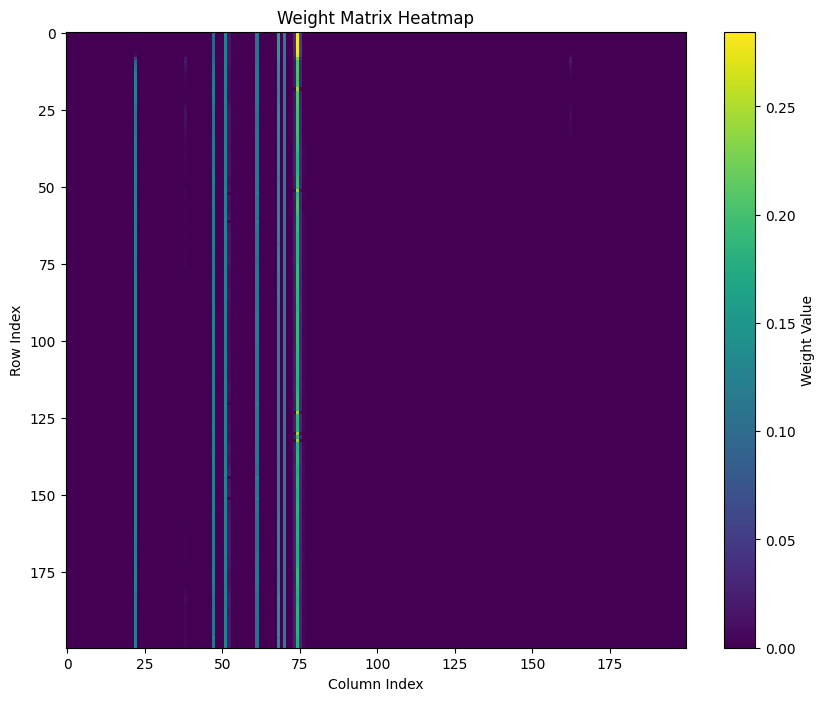

In [16]:
def generate_heatmap(weight_matrix):
    """
    Generates a heatmap from a given weight matrix.
    
    Parameters:
    weight_matrix (numpy.ndarray): A 2D numpy array of shape (200, 200) representing the weights.
    
    Returns:
    None
    """
    if weight_matrix.shape != (200, 200):
        raise ValueError("The weight matrix must be of shape (200, 200)")
    
    plt.figure(figsize=(10, 8))
    plt.imshow(weight_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.title('Weight Matrix Heatmap')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

# Example usage
#caw = decoder_weights.cpu().detach().numpy()
#generate_heatmap(cross_weights.mean(axis=0))
generate_heatmap(self_attention_weights.detach().mean(axis=0))

# Ablation study
In this study we remove the encoder when testing the model

In [16]:
# If you need to load these weights later
model = Transformer(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=3, proj_layer_dim=128, dropout=dropout_rate)
decoder_weights = torch.load('model_decoder/decoder_weights_experiment_batch.pth')
model.decoder_layer.load_state_dict(decoder_weights)

# Save the weights of the FC layer
#torch.save(model.fc.state_dict(), 'model_decoder/transformer_fc_weights.pth')

# To load these weights back into the FC layer later
fc_weights = torch.load('model_decoder/transformer_fc_weights_batch.pth')
model.fc.load_state_dict(fc_weights)

<All keys matched successfully>

In [17]:
class TransformerAblated(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout):
        super(TransformerAblated, self).__init__()
        self.word_embeddings = nn.Embedding(num_spins+1, embed_dim)
        self.decoder_layer = DecoderLayer(embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout)
        self.fc = nn.Linear(embed_dim, num_spins)

    def forward(self, tgt):
        tgt_embedded = self.word_embeddings(tgt)
        dec_output = self.decoder_layer(tgt_embedded, tgt_embedded)
        output = self.fc(dec_output)
        return output
    
    def get_cross_attention_weights(self):
        return self.decoder_layer.cross_attn_weights
    
    def get_self_attention_weights(self):
        return self.decoder_layer.decoder_attn_weights

In [18]:
# Create an instance of the new model
new_model = TransformerAblated(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=3, proj_layer_dim=128, dropout=dropout_rate)

# Load the saved decoder weights
decoder_weights = torch.load('model_decoder/decoder_weights.pth')
new_model.decoder_layer.load_state_dict(decoder_weights)

# Load the saved FC weights
fc_weights = torch.load('model_decoder/transformer_fc_weights.pth')
new_model.fc.load_state_dict(fc_weights)


<All keys matched successfully>

In [21]:
# Define the parameters 
L = 200
embedding_dim = 200
proj_layer_dim = 128
hidden_dim = 200
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-1
num_sequences = 1000
num_epochs = 15
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [22]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="cross_attention_experiment",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Transformer",
    "dataset": "ms_sequences_with_different_probability",
    "epochs": num_epochs,
    }
)

In [23]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
vocab = {0:0,1:1,2:2}
path = '/Users/mariayuffa/semester-project-1/runs'

#training_script(path, model, data_train=enc_train_loader, data_train_dec=dec_train_loader,
#                data_test=enc_test_loader, data_test_dec=dec_test_loader, vocab=vocab, optimizer=optimizer,
#                criterion=criterion, one_hot_flag=False, num_epochs=num_epochs, device=0)

#loss, weights = train(model, new_model, tensor_samples_train, tensor_chains_train, tensor_samples_test, tensor_chains_test, vocab, optimizer, criterion, device=device)
store_cross_attention, store_decoder_attention = training_script_ablated(path, model, new_model, enc_train_loader, dec_train_loader, enc_test_loader, dec_test_loader, vocab, optimizer, criterion, one_hot_flag=False, num_epochs=num_epochs, device=0)
wandb.finish()

  0%|          | 0/15 [00:00<?, ?it/s]/Users/mariayuffa/semester-project-1/utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(masked_sequences, dtype=torch.long), masked_positions
 20%|██        | 32/157 [00:02<00:11, 10.97it/s]


Epoch 1 | Train Loss: 1.9729


  7%|▋         | 1/15 [00:03<00:47,  3.40s/it]

Epoch 1 | Eval Loss: 1.0184


 20%|██        | 32/157 [00:03<00:11, 10.57it/s]


Epoch 2 | Train Loss: 0.7682


 13%|█▎        | 2/15 [00:06<00:45,  3.48s/it]

Epoch 2 | Eval Loss: 0.7981


 20%|██        | 32/157 [00:03<00:11, 10.62it/s]


Epoch 3 | Train Loss: 0.7043


 20%|██        | 3/15 [00:10<00:41,  3.48s/it]

Epoch 3 | Eval Loss: 0.7015


 20%|██        | 32/157 [00:02<00:11, 10.78it/s]


Epoch 4 | Train Loss: 0.7005


 27%|██▋       | 4/15 [00:13<00:38,  3.47s/it]

Epoch 4 | Eval Loss: 0.6968


 20%|██        | 32/157 [00:02<00:11, 10.72it/s]


Epoch 5 | Train Loss: 0.6985


 33%|███▎      | 5/15 [00:17<00:34,  3.47s/it]

Epoch 5 | Eval Loss: 0.6929


 20%|██        | 32/157 [00:03<00:12, 10.11it/s]


Epoch 6 | Train Loss: 0.6949


 40%|████      | 6/15 [00:20<00:31,  3.53s/it]

Epoch 6 | Eval Loss: 0.6929


 20%|██        | 32/157 [00:03<00:11, 10.66it/s]


Epoch 7 | Train Loss: 0.6982


 47%|████▋     | 7/15 [00:24<00:28,  3.51s/it]

Epoch 7 | Eval Loss: 0.6936


 20%|██        | 32/157 [00:03<00:11, 10.55it/s]


Epoch 8 | Train Loss: 0.6991


 53%|█████▎    | 8/15 [00:27<00:24,  3.52s/it]

Epoch 8 | Eval Loss: 0.6951


 20%|██        | 32/157 [00:02<00:11, 10.79it/s]


Epoch 9 | Train Loss: 0.7001


 60%|██████    | 9/15 [00:31<00:20,  3.50s/it]

Epoch 9 | Eval Loss: 0.7062


 20%|██        | 32/157 [00:03<00:11, 10.66it/s]


Epoch 10 | Train Loss: 0.6993


 67%|██████▋   | 10/15 [00:34<00:17,  3.49s/it]

Epoch 10 | Eval Loss: 0.7145


 20%|██        | 32/157 [00:03<00:11, 10.57it/s]


Epoch 11 | Train Loss: 0.7071


 73%|███████▎  | 11/15 [00:38<00:14,  3.53s/it]

Epoch 11 | Eval Loss: 0.7126


 20%|██        | 32/157 [00:02<00:11, 10.90it/s]


Epoch 12 | Train Loss: 0.7035


 80%|████████  | 12/15 [00:41<00:10,  3.49s/it]

Epoch 12 | Eval Loss: 0.6929


 20%|██        | 32/157 [00:03<00:12, 10.26it/s]


Epoch 13 | Train Loss: 0.6948


 87%|████████▋ | 13/15 [00:45<00:07,  3.52s/it]

Epoch 13 | Eval Loss: 0.8218


 20%|██        | 32/157 [00:03<00:11, 10.61it/s]


Epoch 14 | Train Loss: 0.7164


 93%|█████████▎| 14/15 [00:49<00:03,  3.51s/it]

Epoch 14 | Eval Loss: 0.7262


 20%|██        | 32/157 [00:03<00:12, 10.35it/s]


Epoch 15 | Train Loss: 0.7134


100%|██████████| 32/32 [00:00<00:00, 71.20it/s]


Epoch 15 | Eval Loss: 0.6931


eval_loss,█▃▁▁▁▁▁▁▁▁▁▁▄▂▁
train_loss,▁▆▇▆▆▇▆█▆▄█▆▂▅█
eval_loss,0.69307
train_loss,0.72584


# Extracting activations

In [24]:
# loading self-attention weights
#cross_attention_weights = torch.load('model_decoder/transformer_cross_attn_weights.pth')
#cross_attention_weights = new_model.get_cross_attention_weights()
#self_attention_weights = new_model.get_self_attention_weights()

print("Cross-attention weights:", cross_attention_weights.shape)
print("Self-attention weights:", self_attention_weights.shape)

Cross-attention weights: torch.Size([32, 200, 200])
Self-attention weights: torch.Size([8, 200, 200])


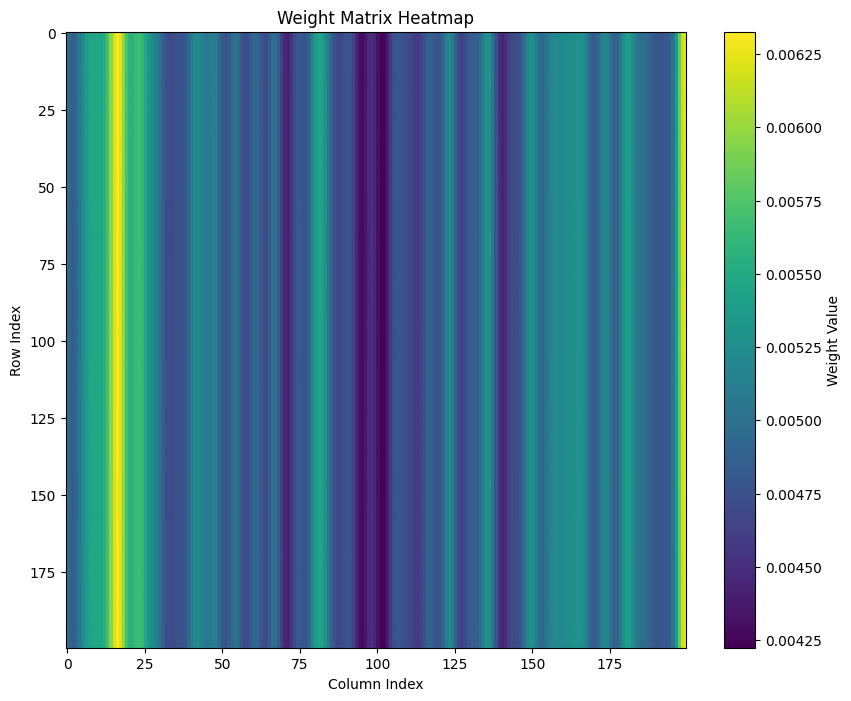

In [25]:
generate_heatmap(cross_attention_weights.mean(0).detach().numpy())

In [ ]:
generate_heatmap(self_attention_weights.mean(0).detach().numpy())